In [3]:
import os
os.chdir("..")

In [4]:
import networkx as nx
import numpy as np
import relegy.embeddings as rle
import relegy.graphs as rlg
import matplotlib.pyplot as plt

In [14]:
# profiler
# profile.py
import time
import os
import psutil
import inspect
import gc


def elapsed_since(start):
    #return time.strftime("%H:%M:%S", time.gmtime(time.time() - start))
    elapsed = time.time() - start
    if elapsed < 1:
        return str(round(elapsed*1000,2)) + "ms", elapsed
    if elapsed < 60:
        return str(round(elapsed, 2)) + "s", elapsed
    if elapsed < 3600:
        return str(round(elapsed/60, 2)) + "min", elapsed
    else:
        return str(round(elapsed / 3600, 2)) + "hrs", elapsed


def get_process_memory():
    process = psutil.Process(os.getpid())
    mi = process.memory_info()
    return mi.rss, mi.vms


def format_bytes(bytes):
    if abs(bytes) < 1000:
        return str(bytes)+"B"
    elif abs(bytes) < 1e6:
        return str(round(bytes/1e3,2)) + "kB"
    elif abs(bytes) < 1e9:
        return str(round(bytes / 1e6, 2)) + "MB"
    else:
        return str(round(bytes / 1e9, 2)) + "GB"


def profile(func, *args, **kwargs):
    global profiling_results
    gc.collect()
    time.sleep(5)
    def wrapper(*args, **kwargs):
        rss_before, vms_before = get_process_memory()
        start = time.time()
        result = func(*args, **kwargs)
        elapsed_time, elapse_time_raw = elapsed_since(start)
        rss_after, vms_after = get_process_memory()
        profiling_results[-1].append((rss_after - rss_before, vms_after - vms_before, elapsed_time, elapsed_time_raw))
        profiling_results[-1].append("RSS: {:>8} | VMS: {:>8} | time: {:>8}"
            .format(format_bytes(rss_after - rss_before),
                    format_bytes(vms_after - vms_before),
                    elapsed_time))
        return result
    if inspect.isfunction(func):
        return wrapper
    elif inspect.ismethod(func):
        return wrapper(*args,**kwargs)
    
@profile
def profile_method(method_class, **kwargs):
    global profiling_results
    profiling_results.append([])
    profiling_results[-1].append(method_class)
    method_class.fast_embed(**kwargs)

In [11]:
@profile
def collect_memory():
    gc.collect()

In [15]:
import os, sys
import contextlib

graph, labels = rlg.generate_clusters_graph(200, 5, 0.03, 0.95)
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]
profiling_results = []
for method_name,method_class in methods:
    print(f"Profiling {method_name}")
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        profile_method(method_class, graph=graph)

print(f"Profiling GCN")
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    profile_method(rle.GCN, graph=graph, Y=labels)


Profiling DNGR


/Users/siemashko/Public/BEng-Thesis/relegy/embeddings/DNGR/__init__.py:148: RuntimeWarning: divide by zero encountered in log
  PPMI = np.log((allsum * scaled_M) / np.dot(rowsum, colsum))


Profiling DeepWalk
Profiling GraRep
Profiling GraphFactorization
Profiling GraphWave
Profiling HARP
Profiling HOPE
Profiling LINE
Profiling LaplacianEigenmaps
Profiling Node2Vec
Profiling SDNE
Profiling Struc2Vec


/Users/siemashko/Public/BEng-Thesis/relegy/embeddings/Struc2Vec/__init__.py:191: RuntimeWarning: invalid value encountered in true_divide
  return np.array(no_diag) / np.array(row_sums)


Profiling GCN


In [16]:
profiling_results

[[relegy.embeddings.DNGR.DNGR,
  (5238784, 5918720, '52.18s'),
  'RSS:   5.24MB | VMS:   5.92MB | time:   52.18s'],
 [relegy.embeddings.DeepWalk.DeepWalk,
  (17518592, 17518592, '5.31s'),
  'RSS:  17.52MB | VMS:  17.52MB | time:    5.31s'],
 [relegy.embeddings.GraRep.GraRep,
  (-18104320, -18104320, '19.28ms'),
  'RSS:  -18.1MB | VMS:  -18.1MB | time:  19.28ms'],
 [relegy.embeddings.GraphFactorization.GraphFactorization,
  (40960, 40960, '1.79s'),
  'RSS:  40.96kB | VMS:  40.96kB | time:    1.79s'],
 [relegy.embeddings.GraphWave.GraphWave,
  (-1277952, -1720320, '18.92ms'),
  'RSS:  -1.28MB | VMS:  -1.72MB | time:  18.92ms'],
 [relegy.embeddings.HARP.HARP,
  (22253568, 20553728, '20.57s'),
  'RSS:  22.25MB | VMS:  20.55MB | time:   20.57s'],
 [relegy.embeddings.HOPE.HOPE,
  (-18178048, -18141184, '16.69ms'),
  'RSS: -18.18MB | VMS: -18.14MB | time:  16.69ms'],
 [relegy.embeddings.LINE.LINE,
  (40960, 40960, '2.22s'),
  'RSS:  40.96kB | VMS:  40.96kB | time:    2.22s'],
 [relegy.embeddi

In [33]:
graph_sizes = list(range(20,220,20))

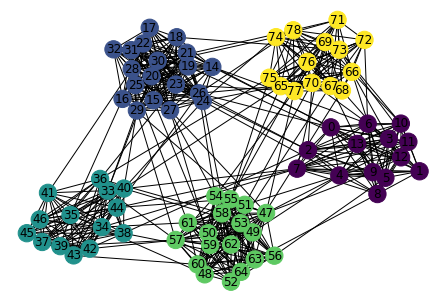

In [34]:
nx.draw(graph, with_labels=True, node_color=labels)